In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# # set the Excel file name and sheet names
# # file_name = 'Dataset.xlsx'
# sheet_names = ['queue1', 'queue2', 'queue3', 'queue4', 'queue5', 'queue6', 'queue7', 'queue8', 'queue9', 'queue10', 'queue11', 'queue12', 'queue13', 'queue14 Part1', 'queue14 Part2', 'queue14 Part3']

# # initialize an empty dataframe to store the combined data
# combined_data = pd.DataFrame()

# # loop through each sheet and append its data to the combined dataframe
# for sheet_name in sheet_names:
#     df = pd.read_excel('Dataset.xlsx', sheet_name=sheet_name)
#     combined_data = pd.concat([combined_data, df])

# # write the combined data to a CSV file
# combined_data.to_csv('Dataset.csv', index=False)


In [3]:
df = pd.read_csv('Dataset.csv')
print(df.shape)
df.head(10)

C:\Users\User\AppData\Local\Temp\ipykernel_13832\1515524340.py:1: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Dataset.csv')


(2783712, 10)


,ServiceID,Time_stamp,Answered,WaitingAnswered,Talking,WaitingAbandoned,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,18,2022-01-01 01:21:15.000,1,37,466.0,NaN,NaN,NaN,Telephone queue 1,NaN
1,18,2022-01-01 02:07:56.000,1,3,360.0,NaN,NaN,NaN,Service ID - 18,NaN
2,18,2022-01-01 02:39:06.000,1,59,197.0,NaN,NaN,NaN,Open 24 hours a day,NaN
3,18,2022-01-01 04:01:33.000,1,13,134.0,NaN,NaN,NaN,NaN,NaN
4,18,2022-01-01 07:05:38.000,1,45,19.0,NaN,NaN,NaN,NaN,NaN
5,18,2022-01-01 07:07:19.000,1,5,224.0,NaN,NaN,NaN,NaN,NaN
6,18,2022-01-01 07:11:36.000,1,3,11.0,NaN,NaN,NaN,NaN,NaN
7,18,2022-01-01 09:39:16.000,1,15,122.0,NaN,NaN,NaN,NaN,NaN
8,18,2022-01-01 10:06:56.000,1,4,99.0,NaN,NaN,NaN,NaN,NaN
9,18,2022-01-01 10:29:50.000,1,17,157.0,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df.drop(['Unnamed: 6','Unnamed: 7','Unnamed: 8','Unnamed: 9'], axis=1)
df = df.rename({'ServiceID':'callgroupid','Time_stamp':'timestamp','Answered':'answered','WaitingAnswered':'gap','Talking':'duration','WaitingAbandoned':'drop'}, axis=1)
df.head(10)

,callgroupid,timestamp,answered,gap,duration,drop
0,18,2022-01-01 01:21:15.000,1,37,466.0,NaN
1,18,2022-01-01 02:07:56.000,1,3,360.0,NaN
2,18,2022-01-01 02:39:06.000,1,59,197.0,NaN
3,18,2022-01-01 04:01:33.000,1,13,134.0,NaN
4,18,2022-01-01 07:05:38.000,1,45,19.0,NaN
5,18,2022-01-01 07:07:19.000,1,5,224.0,NaN
6,18,2022-01-01 07:11:36.000,1,3,11.0,NaN
7,18,2022-01-01 09:39:16.000,1,15,122.0,NaN
8,18,2022-01-01 10:06:56.000,1,4,99.0,NaN
9,18,2022-01-01 10:29:50.000,1,17,157.0,NaN


In [5]:
df['callgroupid'].unique()

array([ 18,  20,  93, 167,  57,  59, 157, 159, 158,  61,  82,  86, 144,
        60, 145, 146], dtype=int64)

In [6]:
replace_dict = {18:1, 20:2, 93:3, 167:4, 57:5, 59:6, 157:7, 159:8, 158:9, 61:10, 82:11, 86:12, 144:13, 60:14, 145:14, 146:14 }
df['callgroupid'] = df['callgroupid'].replace(replace_dict)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.isna().value_counts()

callgroupid  timestamp  answered  gap    duration  drop 
False        False      False     False  False     True     2610734
                                                   False     172945
                                         True      True          33
dtype: int64

In [7]:
print('NaN talk time:\n', df['drop'].isna().value_counts())
print('NaN drop talk time:\n', df['duration'].isna().value_counts())

NaN talk time:
 True     2610767
False     172945
Name: drop, dtype: int64
NaN drop talk time:
 False    2783679
True          33
Name: duration, dtype: int64


In [8]:
df.set_index('timestamp', inplace=True)
resampled_df = df.resample('15T').agg({
    'callgroupid': 'count',
    'duration': 'sum',
    'gap': 'sum'
})

resampled_df = resampled_df.rename(columns={
    'callgroupid': 'callvolume',
    'duration': 'total_duration',
    'waitingtime': 'total_waitingtime'
})

callgroup_volume = df.groupby([df.index.floor('15T'), 'callgroupid']).size().unstack(fill_value=0)
resampled_df = resampled_df.merge(callgroup_volume, left_index=True, right_index=True)

resampled_df['unix_timestamp'] = resampled_df.index.astype(int) / 10**9
resampled_df['Day of Week'] = resampled_df.index.day_name()
print(resampled_df.shape)
resampled_df.head()

resampled_df.head()

(34546, 19)


C:\Users\User\AppData\Local\Temp\ipykernel_13832\929254115.py:17: FutureWarning: The behavior of .astype from datetime64[ns] to int32 is deprecated. In a future version, this astype will return exactly the specified dtype instead of int64, and will raise if that conversion overflows.
  resampled_df['unix_timestamp'] = resampled_df.index.astype(int) / 10**9


,callvolume,total_duration,gap,1,2,3,4,5,6,7,8,9,10,11,12,13,14,unix_timestamp,Day of Week
timestamp,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,12,1748.0,91,0,0,1,0,0,0,1,0,0,0,0,0,1,9,1.640995e+09,Saturday
2022-01-01 00:15:00,26,2663.0,238,0,0,0,0,0,0,1,0,0,0,0,0,3,22,1.640996e+09,Saturday
2022-01-01 00:30:00,57,5625.0,906,0,0,1,2,0,0,1,0,0,0,0,0,14,39,1.640997e+09,Saturday
2022-01-01 00:45:00,54,5869.0,1560,0,0,1,0,0,0,0,0,0,0,0,0,21,32,1.640998e+09,Saturday
2022-01-01 01:00:00,55,4830.0,11112,0,0,1,0,0,0,0,0,0,0,0,0,18,36,1.640999e+09,Saturday


In [9]:
for i in range(1, 15):
    column_name = i
    total_sum = resampled_df[column_name].sum()
    print(f"Sum of column {column_name}: {total_sum}")


Sum of column 1: 50752
Sum of column 2: 11431
Sum of column 3: 101626
Sum of column 4: 11386
Sum of column 5: 52829
Sum of column 6: 1807
Sum of column 7: 57219
Sum of column 8: 5505
Sum of column 9: 7851
Sum of column 10: 3178
Sum of column 11: 17364
Sum of column 12: 2283
Sum of column 13: 263406
Sum of column 14: 2197075


Text(0, 0.5, 'callvolume')

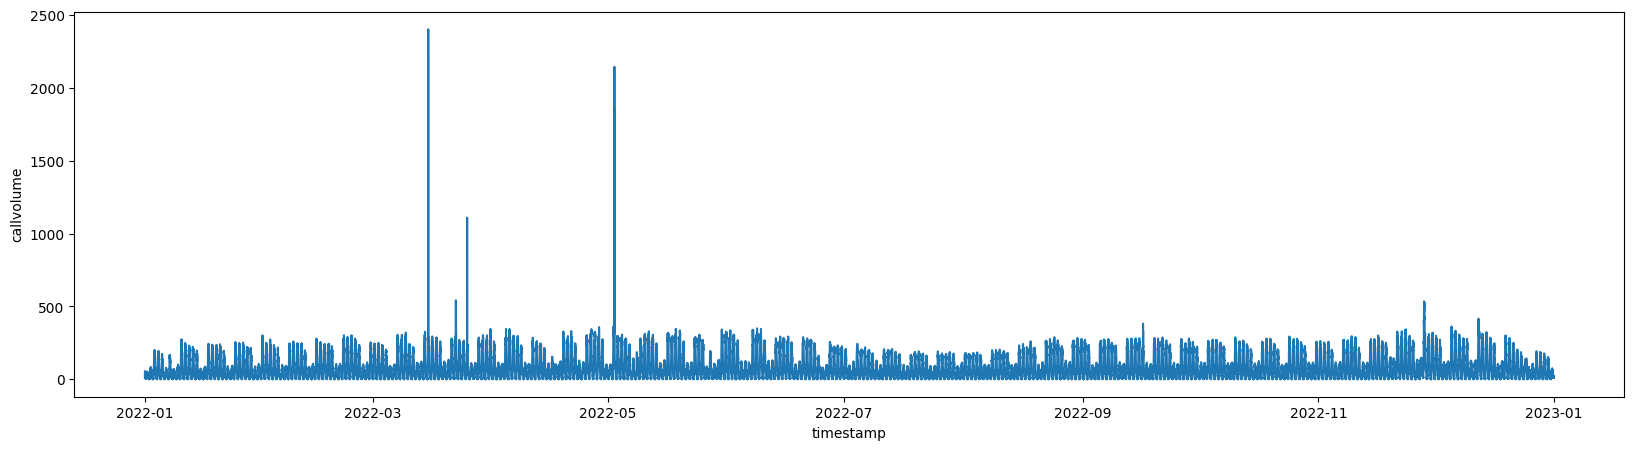

In [10]:
plt.figure(figsize=(20, 5))
plt.plot(resampled_df.index, resampled_df['callvolume'])
plt.xlabel('timestamp')
plt.ylabel('callvolume')

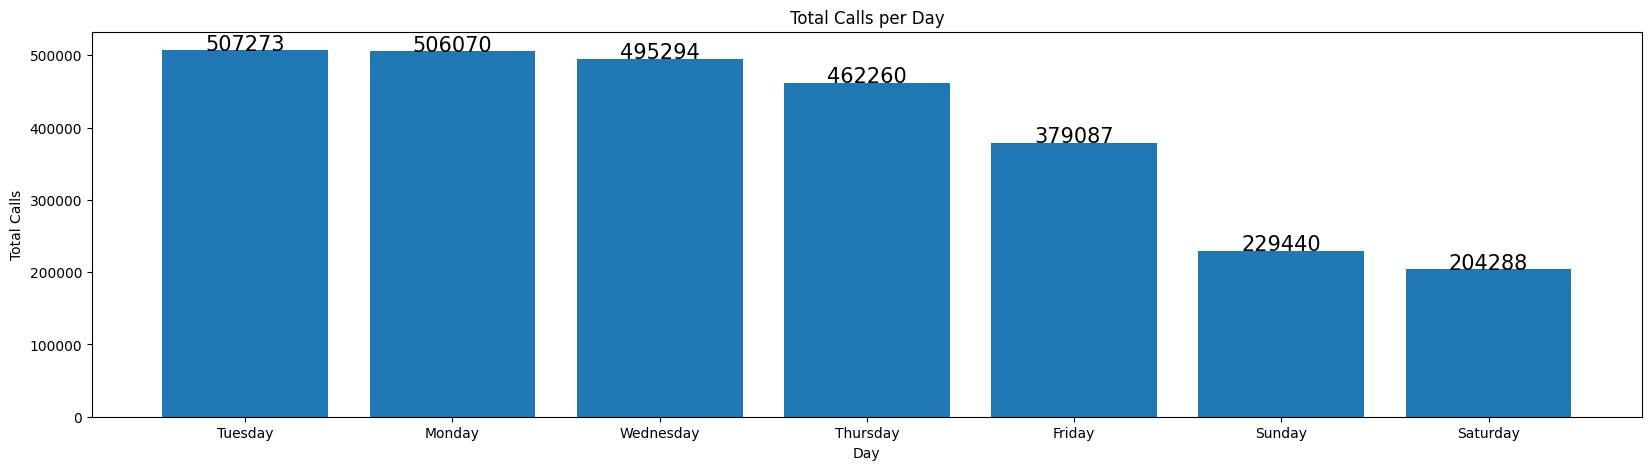

In [11]:
plt.figure(figsize=(20, 5))
call_per_day = resampled_df.groupby('Day of Week')['callvolume'].sum()
call_per_day = call_per_day.sort_values(ascending=False)
plt.bar(call_per_day.index,call_per_day.values)
plt.xlabel('Day')
plt.ylabel('Total Calls')
plt.title('Total Calls per Day')
for i, v in enumerate(call_per_day.values):
    plt.text(i, v+50, str(v), ha='center', fontsize=15)

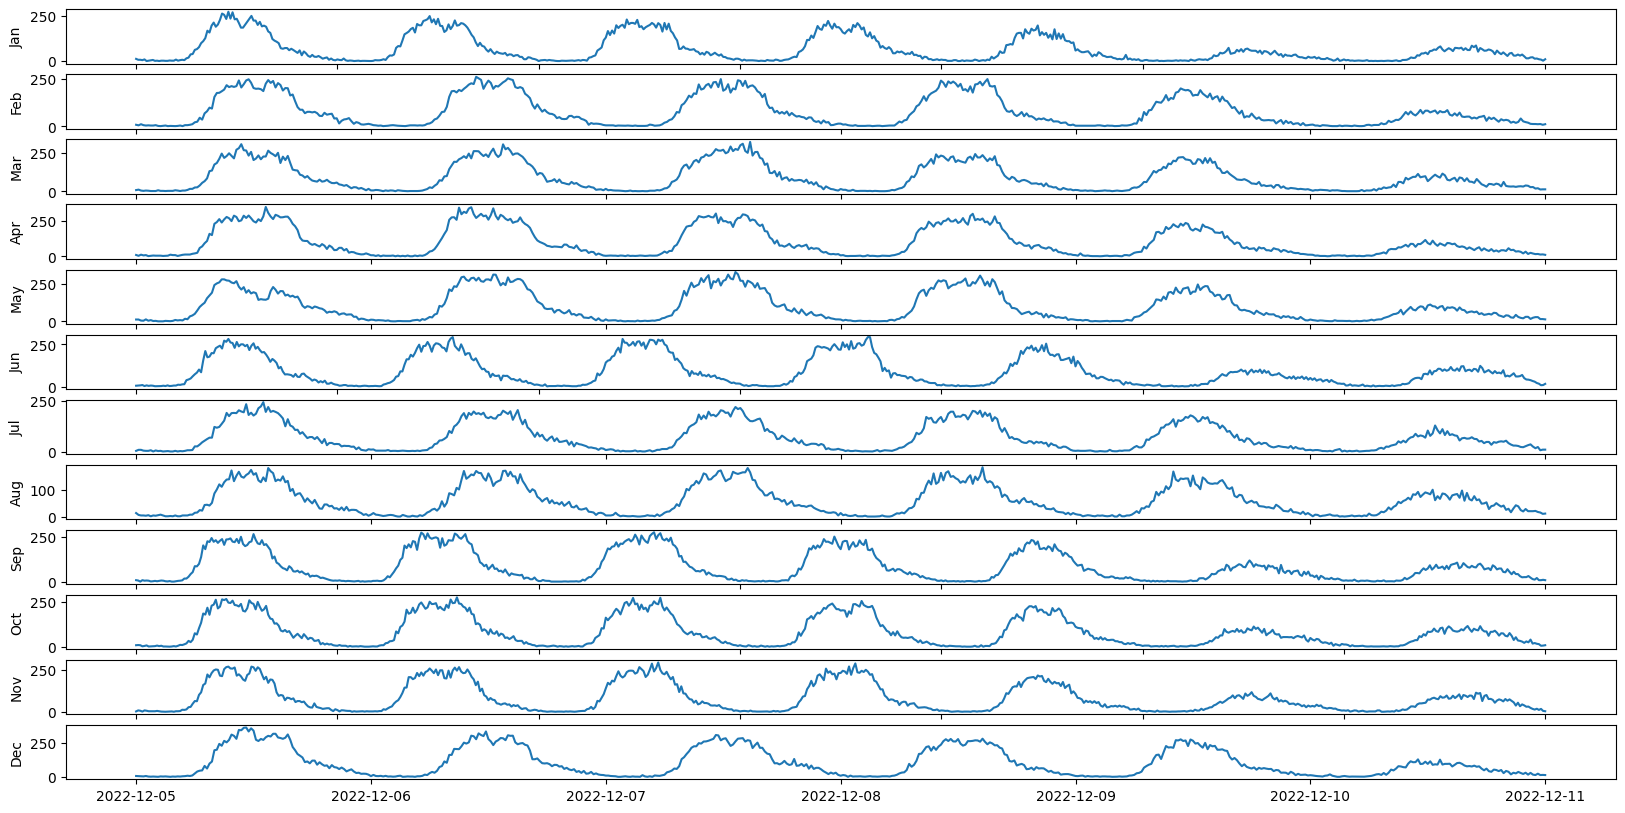

In [12]:
date_ranges = [
    ('Jan', '2022-01-10 00:00:00', '2022-01-17 00:00:00'),
    ('Feb', '2022-02-07 00:00:00', '2022-02-13 00:00:00'),
    ('Mar', '2022-03-07 00:00:00', '2022-03-13 00:00:00'),
    ('Apr', '2022-04-04 00:00:00', '2022-04-10 00:00:00'),
    ('May', '2022-05-09 00:00:00', '2022-05-15 00:00:00'),
    ('Jun', '2022-06-13 00:00:00', '2022-06-20 00:00:00'),
    ('Jul', '2022-07-04 00:00:00', '2022-07-10 00:00:00'),
    ('Aug', '2022-08-01 00:00:00', '2022-08-07 00:00:00'),
    ('Sep', '2022-09-05 00:00:00', '2022-09-12 00:00:00'),
    ('Oct', '2022-10-03 00:00:00', '2022-10-10 00:00:00'),
    ('Nov', '2022-11-07 00:00:00', '2022-11-14 00:00:00'),
    ('Dec', '2022-12-05 00:00:00', '2022-12-11 00:00:00')
]
fig, axs = plt.subplots(len(date_ranges), 1, figsize=(20, 10))
for i, (month, start_date, end_date) in enumerate(date_ranges):
    start_time = pd.Timestamp(start_date)
    end_time = pd.Timestamp(end_date)
    subset = resampled_df['callvolume'].loc[start_time:end_time]
    axs[i].plot(subset.index, subset.values, label='Graph 1')
    axs[i].set_ylabel(month)

Text(0.5, 0.98, 'Call Volume on Mondays by Month')

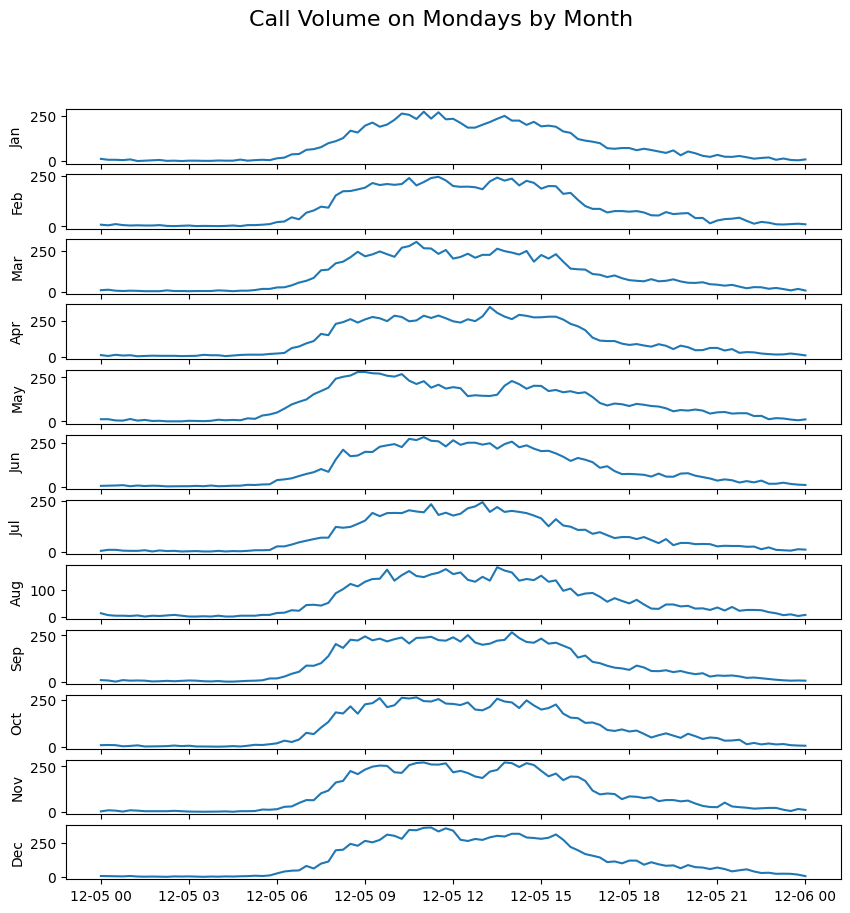

In [13]:
date_ranges = [
    ('Jan', '2022-01-10 00:00:00', '2022-01-11 00:00:00'),
    ('Feb', '2022-02-07 00:00:00', '2022-02-08 00:00:00'),
    ('Mar', '2022-03-07 00:00:00', '2022-03-08 00:00:00'),
    ('Apr', '2022-04-04 00:00:00', '2022-04-05 00:00:00'),
    ('May', '2022-05-09 00:00:00', '2022-05-10 00:00:00'),
    ('Jun', '2022-06-13 00:00:00', '2022-06-14 00:00:00'),
    ('Jul', '2022-07-04 00:00:00', '2022-07-05 00:00:00'),
    ('Aug', '2022-08-01 00:00:00', '2022-08-02 00:00:00'),
    ('Sep', '2022-09-05 00:00:00', '2022-09-06 00:00:00'),
    ('Oct', '2022-10-03 00:00:00', '2022-10-04 00:00:00'),
    ('Nov', '2022-11-07 00:00:00', '2022-11-08 00:00:00'),
    ('Dec', '2022-12-05 00:00:00', '2022-12-06 00:00:00')
]
fig, axs = plt.subplots(len(date_ranges), 1, figsize=(10, 10))
for i, (month, start_date, end_date) in enumerate(date_ranges):
    start_time = pd.Timestamp(start_date)
    end_time = pd.Timestamp(end_date)
    subset = resampled_df['callvolume'].loc[start_time:end_time]
    axs[i].plot(subset.index, subset.values, label='Graph 1')
    axs[i].set_ylabel(month)
fig.suptitle('Call Volume on Mondays by Month', fontsize=16)

Text(0.5, 0.98, 'Call Volume on Tuesdays by Month')

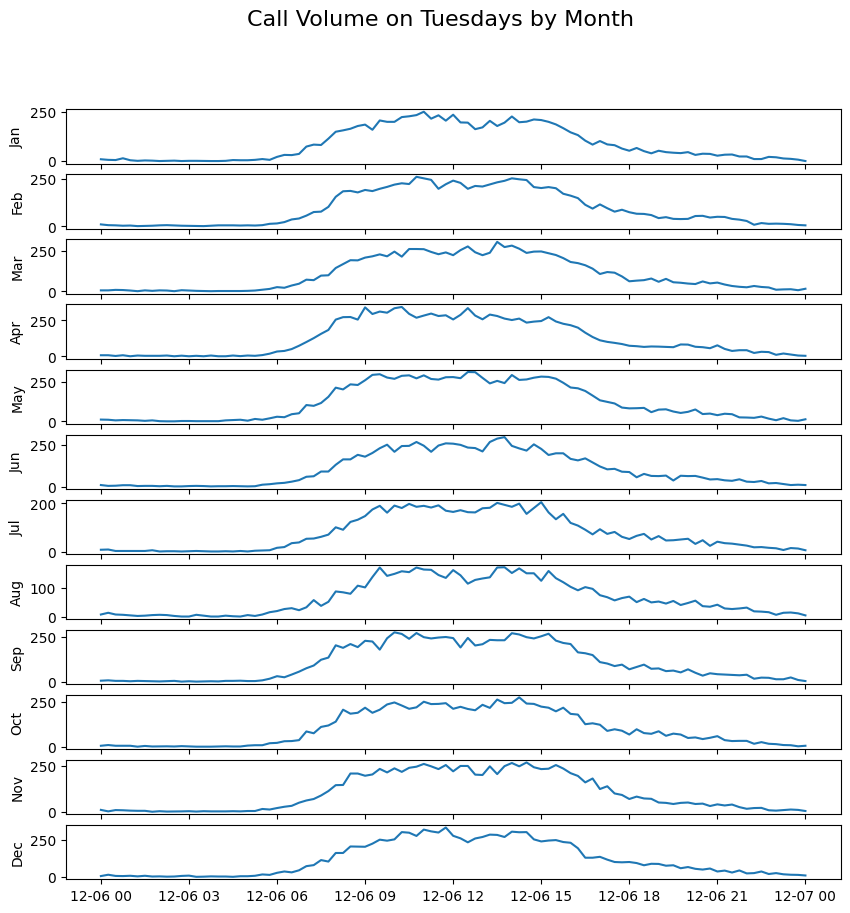

In [14]:
date_ranges = [
    ('Jan', '2022-01-11 00:00:00', '2022-01-12 00:00:00'),
    ('Feb', '2022-02-08 00:00:00', '2022-02-09 00:00:00'),
    ('Mar', '2022-03-08 00:00:00', '2022-03-09 00:00:00'),
    ('Apr', '2022-04-05 00:00:00', '2022-04-06 00:00:00'),
    ('May', '2022-05-10 00:00:00', '2022-05-11 00:00:00'),
    ('Jun', '2022-06-14 00:00:00', '2022-06-15 00:00:00'),
    ('Jul', '2022-07-05 00:00:00', '2022-07-06 00:00:00'),
    ('Aug', '2022-08-02 00:00:00', '2022-08-03 00:00:00'),
    ('Sep', '2022-09-06 00:00:00', '2022-09-07 00:00:00'),
    ('Oct', '2022-10-04 00:00:00', '2022-10-05 00:00:00'),
    ('Nov', '2022-11-08 00:00:00', '2022-11-09 00:00:00'),
    ('Dec', '2022-12-06 00:00:00', '2022-12-07 00:00:00')
]
fig, axs = plt.subplots(len(date_ranges), 1, figsize=(10, 10))
for i, (month, start_date, end_date) in enumerate(date_ranges):
    start_time = pd.Timestamp(start_date)
    end_time = pd.Timestamp(end_date)
    subset = resampled_df['callvolume'].loc[start_time:end_time]
    axs[i].plot(subset.index, subset.values, label='Graph 1')
    axs[i].set_ylabel(month)
fig.suptitle('Call Volume on Tuesdays by Month', fontsize=16)

Text(0.5, 0.98, 'Call Volume on Wednesdays by Month')

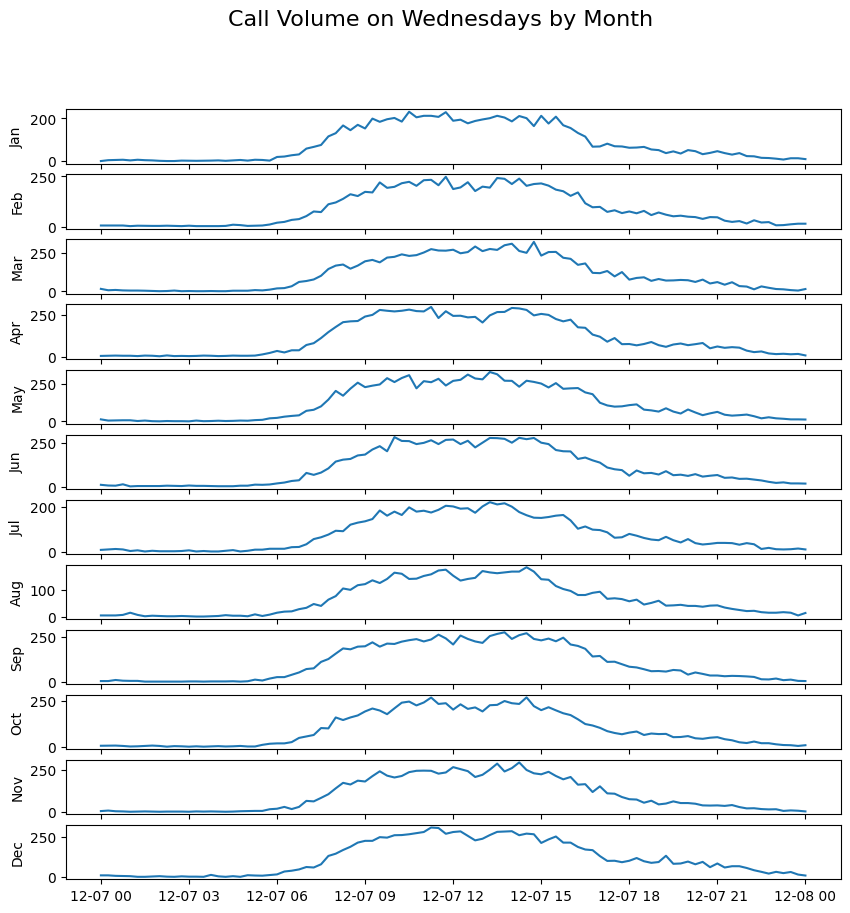

In [15]:
date_ranges = [
    ('Jan', '2022-01-12 00:00:00', '2022-01-13 00:00:00'),
    ('Feb', '2022-02-09 00:00:00', '2022-02-10 00:00:00'),
    ('Mar', '2022-03-09 00:00:00', '2022-03-10 00:00:00'),
    ('Apr', '2022-04-06 00:00:00', '2022-04-07 00:00:00'),
    ('May', '2022-05-11 00:00:00', '2022-05-12 00:00:00'),
    ('Jun', '2022-06-15 00:00:00', '2022-06-16 00:00:00'),
    ('Jul', '2022-07-06 00:00:00', '2022-07-07 00:00:00'),
    ('Aug', '2022-08-03 00:00:00', '2022-08-04 00:00:00'),
    ('Sep', '2022-09-07 00:00:00', '2022-09-08 00:00:00'),
    ('Oct', '2022-10-05 00:00:00', '2022-10-06 00:00:00'),
    ('Nov', '2022-11-09 00:00:00', '2022-11-10 00:00:00'),
    ('Dec', '2022-12-07 00:00:00', '2022-12-08 00:00:00')
]
fig, axs = plt.subplots(len(date_ranges), 1, figsize=(10, 10))
for i, (month, start_date, end_date) in enumerate(date_ranges):
    start_time = pd.Timestamp(start_date)
    end_time = pd.Timestamp(end_date)
    subset = resampled_df['callvolume'].loc[start_time:end_time]
    axs[i].plot(subset.index, subset.values, label='Graph 1')
    axs[i].set_ylabel(month)
fig.suptitle('Call Volume on Wednesdays by Month', fontsize=16)

Text(0.5, 0.98, 'Call Volume on Thursdays by Month')

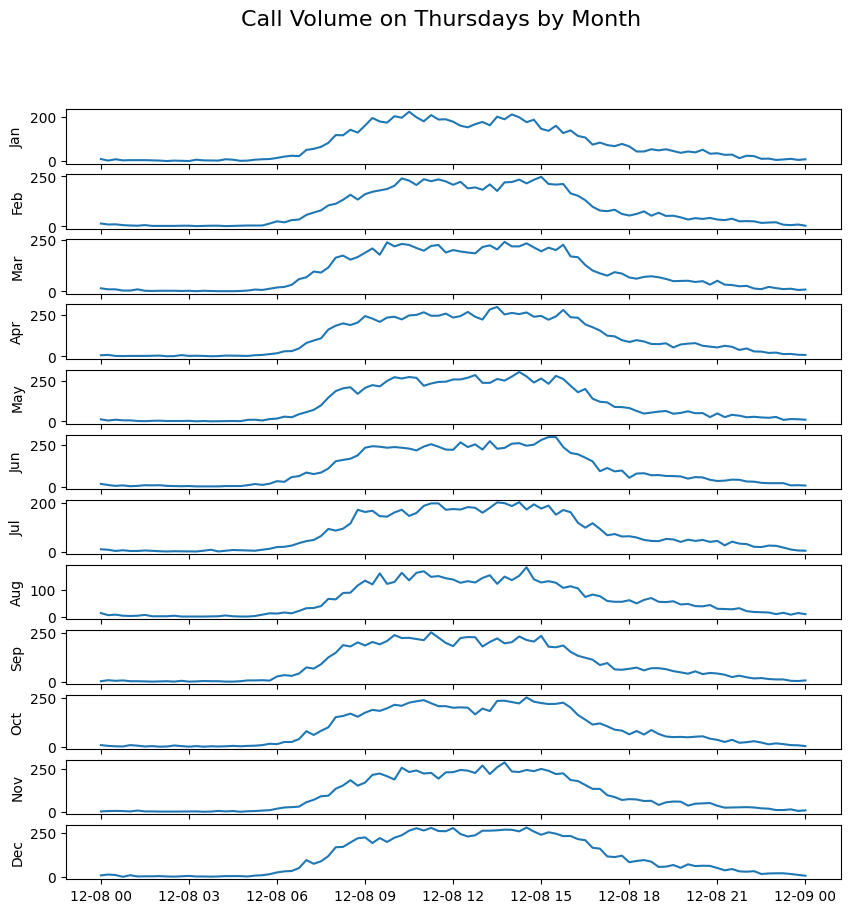

In [16]:
date_ranges = [
    ('Jan', '2022-01-13 00:00:00', '2022-01-14 00:00:00'),
    ('Feb', '2022-02-10 00:00:00', '2022-02-11 00:00:00'),
    ('Mar', '2022-03-10 00:00:00', '2022-03-11 00:00:00'),
    ('Apr', '2022-04-07 00:00:00', '2022-04-08 00:00:00'),
    ('May', '2022-05-12 00:00:00', '2022-05-13 00:00:00'),
    ('Jun', '2022-06-16 00:00:00', '2022-06-17 00:00:00'),
    ('Jul', '2022-07-07 00:00:00', '2022-07-08 00:00:00'),
    ('Aug', '2022-08-04 00:00:00', '2022-08-05 00:00:00'),
    ('Sep', '2022-09-08 00:00:00', '2022-09-09 00:00:00'),
    ('Oct', '2022-10-06 00:00:00', '2022-10-07 00:00:00'),
    ('Nov', '2022-11-10 00:00:00', '2022-11-11 00:00:00'),
    ('Dec', '2022-12-08 00:00:00', '2022-12-09 00:00:00')
]
fig, axs = plt.subplots(len(date_ranges), 1, figsize=(10, 10))
for i, (month, start_date, end_date) in enumerate(date_ranges):
    start_time = pd.Timestamp(start_date)
    end_time = pd.Timestamp(end_date)
    subset = resampled_df['callvolume'].loc[start_time:end_time]
    axs[i].plot(subset.index, subset.values, label='Graph 1')
    axs[i].set_ylabel(month)
fig.suptitle('Call Volume on Thursdays by Month', fontsize=16)

Text(0.5, 0.98, 'Call Volume on Fridays by Month')

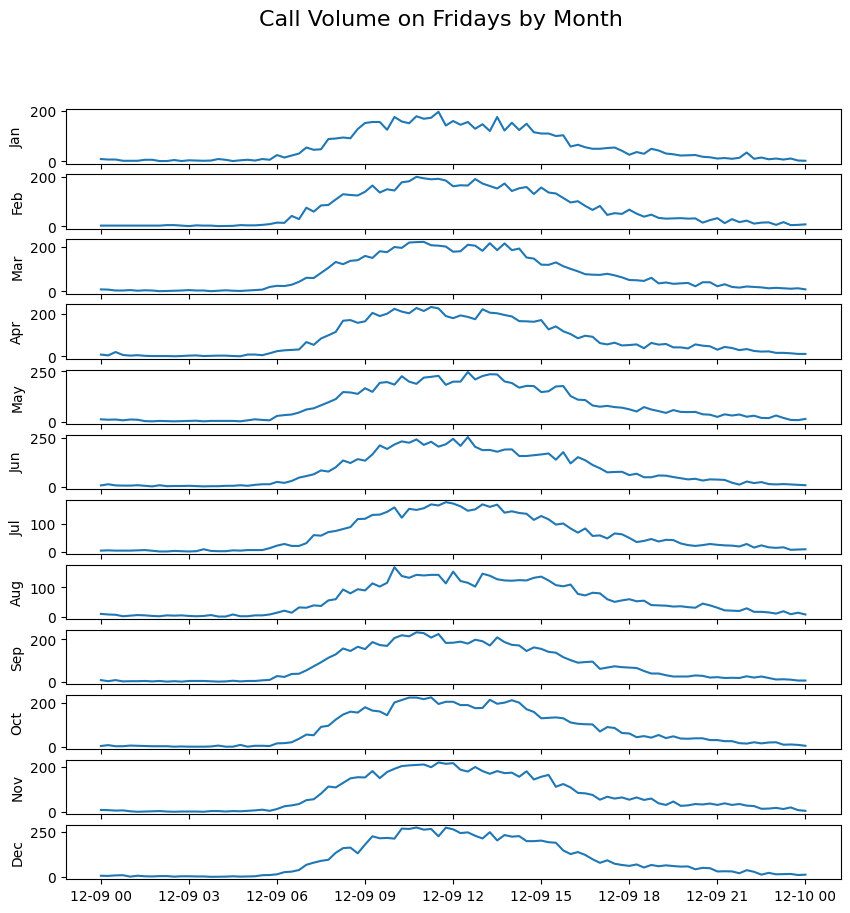

In [17]:
date_ranges = [
    ('Jan', '2022-01-14 00:00:00', '2022-01-15 00:00:00'),
    ('Feb', '2022-02-11 00:00:00', '2022-02-12 00:00:00'),
    ('Mar', '2022-03-11 00:00:00', '2022-03-12 00:00:00'),
    ('Apr', '2022-04-08 00:00:00', '2022-04-09 00:00:00'),
    ('May', '2022-05-13 00:00:00', '2022-05-14 00:00:00'),
    ('Jun', '2022-06-17 00:00:00', '2022-06-18 00:00:00'),
    ('Jul', '2022-07-08 00:00:00', '2022-07-09 00:00:00'),
    ('Aug', '2022-08-05 00:00:00', '2022-08-06 00:00:00'),
    ('Sep', '2022-09-09 00:00:00', '2022-09-10 00:00:00'),
    ('Oct', '2022-10-07 00:00:00', '2022-10-08 00:00:00'),
    ('Nov', '2022-11-11 00:00:00', '2022-11-12 00:00:00'),
    ('Dec', '2022-12-09 00:00:00', '2022-12-10 00:00:00')
]
fig, axs = plt.subplots(len(date_ranges), 1, figsize=(10, 10))
for i, (month, start_date, end_date) in enumerate(date_ranges):
    start_time = pd.Timestamp(start_date)
    end_time = pd.Timestamp(end_date)
    subset = resampled_df['callvolume'].loc[start_time:end_time]
    axs[i].plot(subset.index, subset.values, label='Graph 1')
    axs[i].set_ylabel(month)
fig.suptitle('Call Volume on Fridays by Month', fontsize=16)

Text(0.5, 0.98, 'Call Volume on Saturdays by Month')

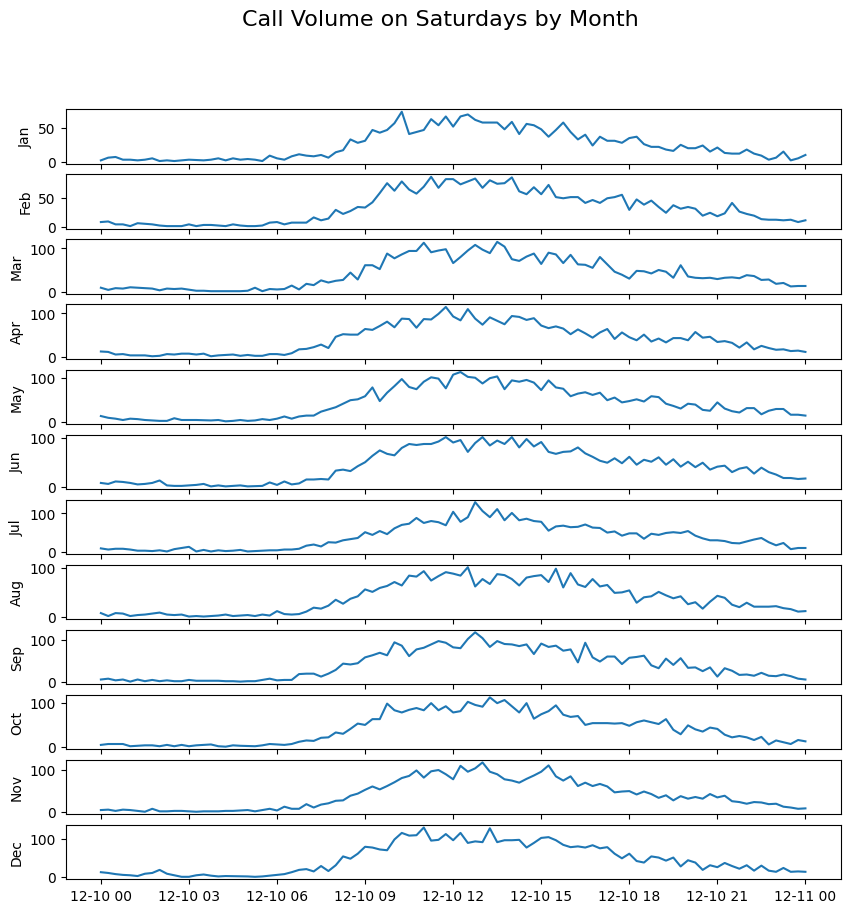

In [18]:
date_ranges = [
    ('Jan', '2022-01-15 00:00:00', '2022-01-16 00:00:00'),
    ('Feb', '2022-02-12 00:00:00', '2022-02-13 00:00:00'),
    ('Mar', '2022-03-12 00:00:00', '2022-03-13 00:00:00'),
    ('Apr', '2022-04-09 00:00:00', '2022-04-10 00:00:00'),
    ('May', '2022-05-14 00:00:00', '2022-05-15 00:00:00'),
    ('Jun', '2022-06-18 00:00:00', '2022-06-19 00:00:00'),
    ('Jul', '2022-07-09 00:00:00', '2022-07-10 00:00:00'),
    ('Aug', '2022-08-06 00:00:00', '2022-08-07 00:00:00'),
    ('Sep', '2022-09-10 00:00:00', '2022-09-11 00:00:00'),
    ('Oct', '2022-10-08 00:00:00', '2022-10-09 00:00:00'),
    ('Nov', '2022-11-12 00:00:00', '2022-11-13 00:00:00'),
    ('Dec', '2022-12-10 00:00:00', '2022-12-11 00:00:00')
]
fig, axs = plt.subplots(len(date_ranges), 1, figsize=(10, 10))
for i, (month, start_date, end_date) in enumerate(date_ranges):
    start_time = pd.Timestamp(start_date)
    end_time = pd.Timestamp(end_date)
    subset = resampled_df['callvolume'].loc[start_time:end_time]
    axs[i].plot(subset.index, subset.values, label='Graph 1')
    axs[i].set_ylabel(month)
fig.suptitle('Call Volume on Saturdays by Month', fontsize=16)

Text(0.5, 0.98, 'Call Volume on Sundays by Month')

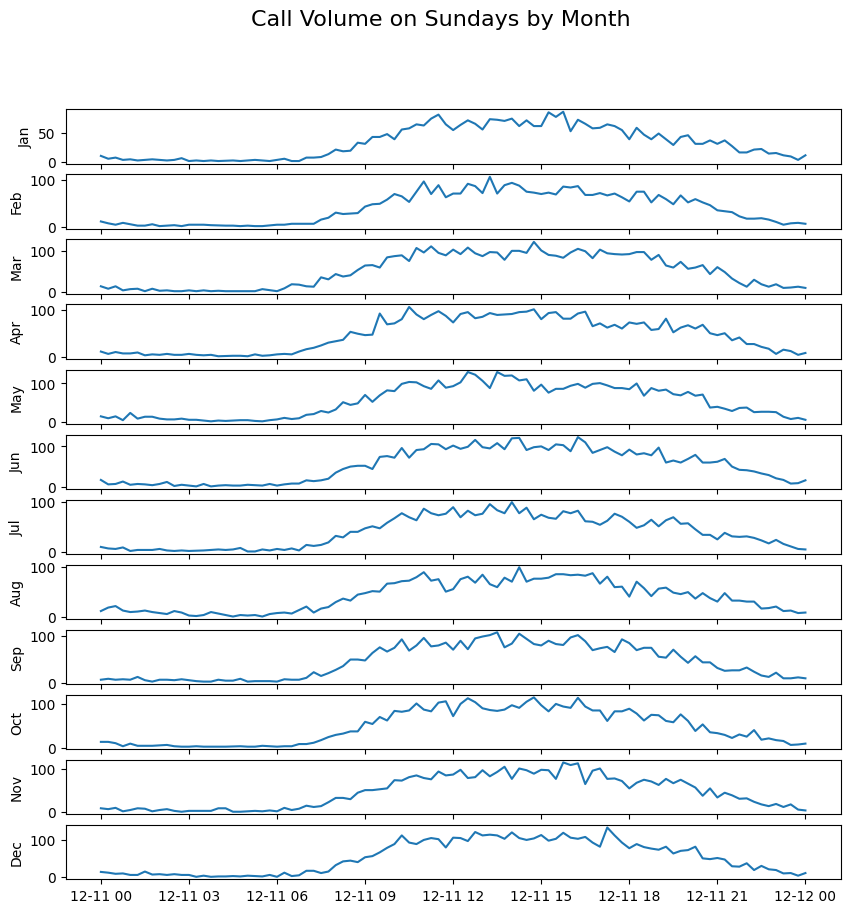

In [19]:
date_ranges = [
    ('Jan', '2022-01-16 00:00:00', '2022-01-17 00:00:00'),
    ('Feb', '2022-02-13 00:00:00', '2022-02-14 00:00:00'),
    ('Mar', '2022-03-13 00:00:00', '2022-03-14 00:00:00'),
    ('Apr', '2022-04-10 00:00:00', '2022-04-11 00:00:00'),
    ('May', '2022-05-15 00:00:00', '2022-05-16 00:00:00'),
    ('Jun', '2022-06-19 00:00:00', '2022-06-20 00:00:00'),
    ('Jul', '2022-07-10 00:00:00', '2022-07-11 00:00:00'),
    ('Aug', '2022-08-07 00:00:00', '2022-08-08 00:00:00'),
    ('Sep', '2022-09-11 00:00:00', '2022-09-12 00:00:00'),
    ('Oct', '2022-10-09 00:00:00', '2022-10-10 00:00:00'),
    ('Nov', '2022-11-13 00:00:00', '2022-11-14 00:00:00'),
    ('Dec', '2022-12-11 00:00:00', '2022-12-12 00:00:00')
]
fig, axs = plt.subplots(len(date_ranges), 1, figsize=(10, 10))
for i, (month, start_date, end_date) in enumerate(date_ranges):
    start_time = pd.Timestamp(start_date)
    end_time = pd.Timestamp(end_date)
    subset = resampled_df['callvolume'].loc[start_time:end_time]
    axs[i].plot(subset.index, subset.values, label='Graph 1')
    axs[i].set_ylabel(month)
fig.suptitle('Call Volume on Sundays by Month', fontsize=16)

In [20]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# # Create the scaler object
# scaler = MinMaxScaler()

# # Normalize both features and target variable
# X = resampled_df[['unix_timestamp']]
# y = resampled_df['callvolume']

# X_normalized = scaler.fit_transform(X)
# y_normalized = scaler.fit_transform(y.values.reshape(-1, 1))

# # Split the normalized data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)

# # Create the XGBoost model
# model = xgb.XGBRegressor()

# # Fit the model on the training data
# model.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = model.predict(X_test)

# # Denormalize the predicted values
# y_pred_denormalized = scaler.inverse_transform(y_pred.reshape(-1, 1))

# # Print the mean squared error

# mse = mean_squared_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# mae = mean_absolute_error(y_test,y_pred)

# print('Mean Squared Error:', mse)
# print('Root Mean Squared Error:', rmse)
# print('Mean Absolute Error:', mae)


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

df_nn = resampled_df[['callvolume', 'unix_timestamp']]
df_nn.head()

# Create the scaler objects
scaler_callvolume = MinMaxScaler()
scaler_unix_timestamp = MinMaxScaler()

train_size = int(len(df_nn) * 0.8)
train_data, test_data = df_nn.iloc[:train_size], df_nn.iloc[train_size:]

train_data_scaled = np.concatenate([
    scaler_callvolume.fit_transform(train_data[['callvolume']]),
    scaler_unix_timestamp.fit_transform(train_data[['unix_timestamp']])
], axis=1)
test_data_scaled = np.concatenate([
    scaler_callvolume.transform(test_data[['callvolume']]),
    scaler_unix_timestamp.transform(test_data[['unix_timestamp']])
], axis=1)

# Reshape the data
X_train = []
y_train = []
for i in range(60, train_data_scaled.shape[0]):
    X_train.append(train_data_scaled[i-60:i, 1])  # Use only the unix_timestamp feature
    y_train.append(train_data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
y_test = []
for i in range(60, test_data_scaled.shape[0]):
    X_test.append(test_data_scaled[i-60:i, 1])  # Use only the unix_timestamp feature
    y_test.append(test_data_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape X_train and X_test
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Create the XGBoost model
model = xgb.XGBRegressor()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Denormalize the predicted values
y_pred_denormalized = np.zeros((y_pred.shape[0], 2))
y_pred_denormalized[:, 0] = scaler_callvolume.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_pred_denormalized[:, 1] = scaler_unix_timestamp.inverse_transform(X_test[:, -1].reshape(-1, 1)).flatten()

# Print the mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)


Mean Squared Error: 0.002004069293257502
Root Mean Squared Error: 0.04476683251311736
Mean Absolute Error: 0.029982193990585198


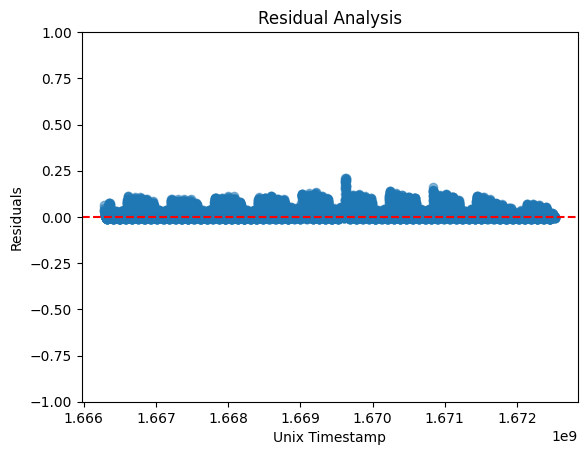

In [22]:
import matplotlib.pyplot as plt

# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.scatter(y_pred_denormalized[:, 1], residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.ylim(-1, 1)
plt.xlabel('Unix Timestamp')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()


In [23]:
# df_nn = resampled_df[['callvolume','unix_timestamp']]
# df_nn.head()

Univariate RNN

In [24]:
# from keras.models import Sequential
# from keras.layers import Dense, LSTM, Dropout

# train_size = int(len(df_nn) * 0.8)
# train_data, test_data = df_nn.iloc[:train_size], df_nn.iloc[train_size:]

# train_data_scaled = scaler.fit_transform(train_data)
# test_data_scaled = scaler.transform(test_data)

# # Reshape the data
# X_train = []
# y_train = []
# for i in range(60, train_data_scaled.shape[0]):
#     X_train.append(train_data_scaled[i-60:i, 0:2])
#     y_train.append(train_data_scaled[i, 0])
# X_train, y_train = np.array(X_train), np.array(y_train)

# X_test = []
# y_test = []
# for i in range(60, test_data_scaled.shape[0]):
#     X_test.append(test_data_scaled[i-60:i, 0:2])
#     y_test.append(test_data_scaled[i, 0])
# X_test, y_test = np.array(X_test), np.array(y_test)

# model = Sequential()
# model.add(LSTM(units=60, return_sequences=True, input_shape=(X_train.shape[1], 2)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50))
# model.add(Dropout(0.2))
# model.add(Dense(units=1, activation='linear'))



In [25]:
# model.summary()

In [26]:
# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# # Fit the model
# history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

# # Evaluate the model
# test_loss, test_mae = model.evaluate(X_test, y_test)

In [27]:
# model.summary()

In [28]:
# # Make predictions on the test data
# y_pred = model.predict(X_test)

In [29]:
# import math
# # y_pred_denormalized = scaler.inverse_transform(y_pred.reshape(-1, 1))
# # y_test_denormalized = scaler.inverse_transform(y_test.reshape(-1, 1))

# mse = mean_squared_error(y_test, y_pred)
# rmse = math.sqrt(mse)
# mae = test_mae

# print('Mean Squared Error:', mse)
# print('Root Mean Squared Error:', rmse)
# print('Mean Absolute Error:', mae)

In [30]:
# # Compute the residuals
# residuals = y_test.flatten() - y_pred.flatten()

# # Plotting the residuals
# plt.scatter(y_pred.flatten(), residuals)
# plt.axhline(y=0, color='red', linestyle='--')
# plt.ylim(-1, 1)
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')
# plt.title('Residual Analysis')
# plt.show()